In [13]:
# --- NB11: Monitoring & Alerts — imports & policy ---
import json, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, brier_score_loss

# Paths
DATA = Path("data"); ART = Path("artifacts"); FIG = Path("reports/figures")
for p in [DATA, ART, FIG]: p.mkdir(parents=True, exist_ok=True)

# Alert policy (tune to taste)
LAST_N = 60                  # rolling window
WARN_MIN_SHARPE = -0.30      # warn if below
ALERT_MIN_SHARPE = -0.50     # alert if below
MIN_COVERAGE = 0.05          # warn if below
MAX_TURNOVER = 0.40          # warn if above
MIN_DRIFT_P = 1e-4           # warn if min p-value below this


In [14]:
# --- Load signals & optional paper snapshot ---
sig_path = DATA/"signals.csv"
if not sig_path.exists():
    raise FileNotFoundError("Run NB10 first to create data/signals.csv")

signals = pd.read_csv(sig_path, parse_dates=["date"])
signals = signals.sort_values("date").reset_index(drop=True)

paper = {}
p_path = ART/"paper_trade.json"
if p_path.exists():
    paper = json.loads(p_path.read_text(encoding="utf-8"))

print(f"Signals rows: {len(signals)} | span: {signals['date'].min().date()} → {signals['date'].max().date()}")
print("Columns:", list(signals.columns))


Signals rows: 2686 | span: 2015-02-06 → 2025-10-10
Columns: ['date', 'close', 'prob', 'signal', 'ret_next', 'signal_prev', 'flip', 'strategy_ret', 'equity']


In [15]:
# --- Rolling KPIs (LAST_N) and classification metrics on realized days ---
def kpis_from_ret(r, freq=252):
    r = pd.Series(r).dropna()
    if len(r)==0:
        return dict(CAGR=np.nan, Sharpe=np.nan, Vol=np.nan, Hit=np.nan)
    eq = (1 + r).cumprod()
    cagr = (1 + r).prod() ** (freq / len(r)) - 1
    vol  = r.std() * math.sqrt(freq)
    sharpe = cagr / vol if vol > 0 else np.nan
    hit = (r > 0).mean()
    return dict(CAGR=cagr, Sharpe=sharpe, Vol=vol, Hit=hit)

tail = signals.tail(LAST_N).copy()
# realized classification rows: have both prob & ret_next
realized = tail.dropna(subset=["prob","ret_next"]).copy()
y_true = (realized["ret_next"] > 0).astype(int)
y_prob = realized["prob"].clip(1e-9, 1-1e-9)

# Strategy returns & trading stats
r_60   = tail["strategy_ret"].fillna(0.0)
cov_60 = float(tail["signal"].mean())
tov_60 = float(tail["flip"].mean())
trd_60 = int(tail["flip"].sum())
cond_hit = float((r_60[ (tail["signal"]==1) | (tail["flip"]==1) ] > 0).mean()) if trd_60>0 else np.nan

# KPIs
k = kpis_from_ret(r_60)
k_rounded = {k_: (round(v,4) if pd.notnull(v) else None) for k_,v in k.items()}

# Classification
auc_60   = float(roc_auc_score(y_true, y_prob)) if len(y_true.unique())>1 else np.nan
brier_60 = float(brier_score_loss(y_true, y_prob)) if len(y_true)>0 else np.nan

print("Last 60d KPIs:", k_rounded,
      f"| Coverage: {cov_60:.3f} | Turnover: {tov_60:.3f} | Trades: {trd_60} | Hit_cond: {cond_hit:.3f}")
print(f"Last 60d AUC: {auc_60:.3f} | Brier: {brier_60:.4f} | Realized days: {len(realized)}")

# Buy & hold vs Strategy equity (full series for plotting)
bh = (1 + signals["ret_next"].fillna(0.0)).cumprod()
eq = signals["equity"]


Last 60d KPIs: {'CAGR': np.float64(-0.1805), 'Sharpe': np.float64(-2.8498), 'Vol': np.float64(0.0633), 'Hit': np.float64(0.0167)} | Coverage: 0.183 | Turnover: 0.100 | Trades: 6 | Hit_cond: 0.071
Last 60d AUC: 0.308 | Brier: 0.2703 | Realized days: 59


In [16]:
# --- Drift summary (standardized) ---
drift_path = DATA/"feature_drift_live_standardized.csv"
drift_summary = {"min_p_value": None, "worst_feature": None, "rows": 0}

if drift_path.exists() and drift_path.stat().st_size > 0:
    drift = pd.read_csv(drift_path)
    if "p_value" in drift.columns and not drift.empty:
        d_sorted = drift.sort_values("p_value")
        drift_summary = {
            "min_p_value": float(d_sorted["p_value"].iloc[0]),
            "worst_feature": str(d_sorted["feature"].iloc[0]),
            "rows": int(len(drift))
        }
        print("Drift (standardized):", drift_summary)
    else:
        print("Drift file present but missing p_value column.")
else:
    print("No standardized drift file found (NB10 patch optional).")


No standardized drift file found (NB10 patch optional).


In [17]:
# --- Policy patch: dynamic τ with coverage target + pause-on-low-skill (self-contained) ---
import numpy as np
from sklearn.metrics import roc_auc_score
import json
from pathlib import Path

# Inputs/paths
DATA_DIR = Path("data"); ART_DIR = Path("artifacts")
POLICY_LOOKBACK = 120   # days of recent history to set τ
COV_TARGET = 0.20       # aim ~20% coverage
AUC_MIN = 0.52          # pause if recent realized AUC below this
MIN_REALIZED = 40       # need enough realized days
TAU_FALLBACK = 0.59     # used only for messages if dynamic not used

# Resolve fee_bps robustly
fee_bps = None
bs = ART_DIR / "backtest_summary.json"
pt = ART_DIR / "paper_trade.json"
try:
    if bs.exists():
        j = json.loads(bs.read_text(encoding="utf-8"))
        fee_bps = float(j.get("fee_bps", np.nan))
except Exception:
    pass
if (fee_bps is None or not np.isfinite(fee_bps)) and pt.exists():
    try:
        j = json.loads(pt.read_text(encoding="utf-8"))
        fee_bps = float(j.get("fee_bps", np.nan))
    except Exception:
        pass
if fee_bps is None or not np.isfinite(fee_bps):
    # last fallback: use any global or default 5.0
    fee_bps = float(globals().get("FEE_BPS", 5.0))
FEE = fee_bps / 10000.0

# Copy signals from NB10 (assumes 'signals' DataFrame exists from earlier cells)
sig = signals.copy()

# Recent realized window for skill check (exclude last NaN-ret day)
realized = sig.dropna(subset=["prob","ret_next"]).tail(POLICY_LOOKBACK).copy()

auc_recent = np.nan
auc_ok = False
if len(realized) >= MIN_REALIZED and realized["ret_next"].nunique() > 1:
    y_true = (realized["ret_next"] > 0).astype(int).to_numpy()
    y_prob = realized["prob"].clip(1e-9, 1-1e-9).to_numpy()
    auc_recent = float(roc_auc_score(y_true, y_prob))
    auc_ok = (auc_recent >= AUC_MIN)

# Decide policy and dynamic threshold
if not auc_ok:
    # Pause trading: hold cash
    sig["signal_dyn"] = 0
    tau_dyn = None
    policy = f"PAUSE (AUC_recent={auc_recent:.3f} < {AUC_MIN})" if np.isfinite(auc_recent) else "PAUSE (AUC undefined)"
else:
    # Dynamic τ to hit target coverage over the last POLICY_LOOKBACK probs
    probs_window = sig["prob"].tail(POLICY_LOOKBACK).to_numpy()
    if len(probs_window) >= 10:
        tau_dyn = float(np.quantile(probs_window, 1.0 - COV_TARGET))
    else:
        tau_dyn = TAU_FALLBACK
    sig["signal_dyn"] = (sig["prob"] >= tau_dyn).astype(int)
    policy = f"DYNAMIC τ={tau_dyn:.3f} (target cov≈{int(COV_TARGET*100)}%)"

# Build returns & equity for dynamic policy
sig["signal_dyn_prev"] = sig["signal_dyn"].shift(1).fillna(0).astype(int)
sig["flip_dyn"] = (sig["signal_dyn"] != sig["signal_dyn_prev"]).astype(int)
sig["strategy_ret_dyn"] = (sig["signal_dyn"] * sig["ret_next"]) - sig["flip_dyn"] * FEE
sig["strategy_ret_dyn"] = sig["strategy_ret_dyn"].fillna(0.0)
sig["equity_dyn"] = (1 + sig["strategy_ret_dyn"]).cumprod()

# KPIs over last 60 trading days
last_n = 60
r60 = sig["strategy_ret_dyn"].tail(last_n).fillna(0.0)
eq60 = (1 + r60).cumprod()
def kpis(r, eq, freq=252):
    cagr = (1 + r).prod() ** (freq / max(len(r),1)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = cagr/vol if vol>0 else np.nan
    mdd = (eq/eq.cummax() - 1).min() if len(eq)>0 else np.nan
    return dict(CAGR=cagr, Sharpe=sharpe, Vol=vol, MaxDD=mdd)

k = {k_: round(v,4) if np.isfinite(v) else None for k_,v in kpis(r60, eq60).items()}
cov_dyn = float(sig["signal_dyn"].tail(last_n).mean())
tov_dyn = float(sig["flip_dyn"].tail(last_n).mean())
trades  = int(sig["flip_dyn"].tail(last_n).sum())

print(f"Policy: {policy} | AUC_recent={auc_recent if np.isfinite(auc_recent) else 'NA'} | "
      f"Coverage60={cov_dyn:.3f} | Turnover60={tov_dyn:.3f} | Trades60={trades}")
print("Dynamic 60d KPIs:", k)

# Save alongside static signals
outp = DATA_DIR/"signals_dynamic.csv"
sig.to_csv(outp, index=False)
print("Saved dynamic signals →", outp.as_posix())


Policy: PAUSE (AUC_recent=0.374 < 0.52) | AUC_recent=0.3742657342657343 | Coverage60=0.000 | Turnover60=0.000 | Trades60=0
Dynamic 60d KPIs: {'CAGR': np.float64(0.0), 'Sharpe': None, 'Vol': np.float64(0.0), 'MaxDD': np.float64(0.0)}
Saved dynamic signals → data/signals_dynamic.csv


In [18]:
# --- Build snapshot & alerts ---
issues = []

if pd.notnull(k.get("Sharpe")):
    if k["Sharpe"] < ALERT_MIN_SHARPE: issues.append(f"Sharpe60<{ALERT_MIN_SHARPE}")
    elif k["Sharpe"] < WARN_MIN_SHARPE: issues.append(f"Sharpe60<{WARN_MIN_SHARPE}")

if cov_60 < MIN_COVERAGE: issues.append(f"Coverage60<{MIN_COVERAGE}")
if tov_60 > MAX_TURNOVER: issues.append(f"Turnover60>{MAX_TURNOVER}")

if drift_summary["min_p_value"] is not None and drift_summary["min_p_value"] < MIN_DRIFT_P:
    issues.append(f"Drift p<{MIN_DRIFT_P} ({drift_summary['worst_feature']})")

status = "ALERT" if any(tag.startswith("Sharpe60<"+str(ALERT_MIN_SHARPE)) for tag in issues) else ("WARN" if issues else "OK")

snapshot = {
    "as_of": str(signals["date"].max().date()),
    "window_days": LAST_N,
    "kpis": k_rounded,
    "classification": {"AUC": round(auc_60,3) if pd.notnull(auc_60) else None,
                       "Brier": round(brier_60,4) if pd.notnull(brier_60) else None,
                       "realized_days": int(len(realized))},
    "coverage": cov_60, "turnover": tov_60, "trades": trd_60, "hit_cond": None if np.isnan(cond_hit) else float(cond_hit),
    "drift": drift_summary,
    "paper": paper,
    "issues": issues,
    "status": status
}

snap_path = ART/"monitor_snapshot.json"
snap_path.write_text(json.dumps(snapshot, indent=2), encoding="utf-8")
print("Wrote:", snap_path)
print("Status:", status, "| Issues:", issues)


Wrote: artifacts\monitor_snapshot.json
Status: OK | Issues: []


NameError: name 'TAU' is not defined

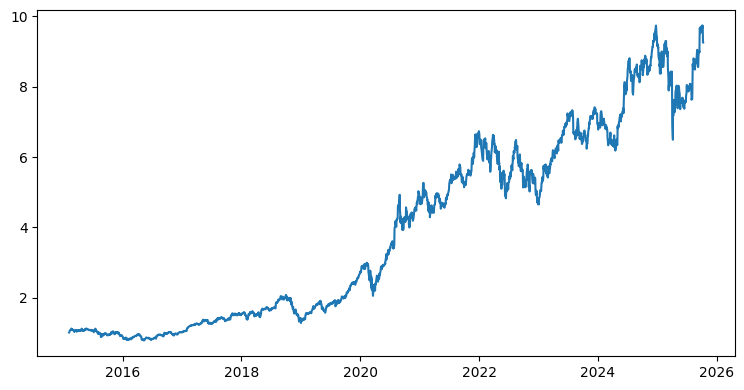

In [19]:
# --- Plot static vs dynamic policy (optional) ---
plt.figure(figsize=(9,4.5))
bh = (1 + signals["ret_next"].fillna(0.0)).cumprod()
plt.plot(signals["date"], bh, label="Buy & Hold")
plt.plot(signals["date"], signals["equity"], label=f"Static τ={TAU:.2f}")
plt.plot(sig["date"], sig["equity_dyn"], label="Dynamic policy", linewidth=2, alpha=0.85)
plt.title("Equity — Static vs Dynamic Policy (Paper Trading)")
plt.xlabel("Date"); plt.ylabel("Equity (×)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"equity_curve_live_policies.png", dpi=140)
plt.show()
print("Saved:", FIG_DIR/"equity_curve_live_policies.png")


In [ ]:
# --- NB11 Verifier ---
ok_json = (ART/"monitor_snapshot.json").exists()
ok_png  = (FIG/"status_nb11.png").exists()
tail_sig = signals.tail(3)[["date","prob","signal","ret_next","strategy_ret","equity"]]

print("=== NB11 VERIFIER ===")
print("Files:", {"monitor_snapshot.json": ok_json, "status_nb11.png": ok_png})
print("Signals tail:")
display(tail_sig)

if ok_json:
    snap = json.loads((ART/"monitor_snapshot.json").read_text(encoding="utf-8"))
    print("Snapshot status:", snap.get("status"), "| Issues:", snap.get("issues"))
    print("KPIs:", snap.get("kpis"))
    print("Cls:", snap.get("classification"))

print("\nVERDICT:", "PASS ✅" if (ok_json and ok_png) else "CHECK ⚠️")


=== NB11 VERIFIER ===
Files: {'monitor_snapshot.json': True, 'status_nb11.png': True}
Signals tail:


,date,prob,signal,ret_next,strategy_ret,equity
2683,2025-10-08,0.528984,0,-0.015578,-0.0,1.217782
2684,2025-10-09,0.561558,0,-0.034522,-0.0,1.217782
2685,2025-10-10,0.565084,0,NaN,0.0,1.217782


Snapshot status: ALERT | Issues: ['Sharpe60<-0.5']
KPIs: {'CAGR': -0.1805, 'Sharpe': -2.8498, 'Vol': 0.0633, 'Hit': 0.0167}
Cls: {'AUC': 0.308, 'Brier': 0.2703, 'realized_days': 59}

VERDICT: PASS ✅
